# Analysing Herald Articles

In [1]:
OVERWRITE = True

Here I'll be analysing over 300,000 articles from the NZ Herald.

In [2]:
# The usual suspects
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# For this analysis
import os
import re
import json
import jellyfish

The articles are recorded as json. Here is one example:

In [3]:
! head -n 1 ../news/nzherald.json

{"headline": [" Live: Christchurch mosque shootings - NZ in mourning as 49 people killed and more than 40 injured in terror attack ", " "], "date": "16 Mar, 2019 9:15am", "url": "https://www.nzherald.co.nz/nz/news/article.cfm?c_id=1&objectid=12213236", "syndicator_name": ["NZ Herald"], "byline": null, "paragraphs": [" KEY POINTS:\n• 36 mins of terror: Police confirm sole gunman responsible for both mosque shootings\n• PM Ardern says gunman \"absolutely\" intended to continue his attack\n• Australian-born Dunedin resident Brenton Harrison Tarrant appeared in court today \n• 49 are confirmed dead, victims range from 2 to older than 60\n• 12 people remain in critical care as survivors' harrowing tales emerge\n• Attorney General says semi-automatic weapons will be banned \n• Kiwis have already donated more than $2.5m", " New Zealand is in mourning after the deadly massacre at two Christchurch mosques. Join us for live updates as the country comes to grips with the tragedy."]}


In [4]:
! head ../news/nzherald.json > ../data/nzherald_sample.json

In [5]:
%%time
herald_data = pd.read_json("../news/nzherald.json", lines = True)
herald_data.head()

CPU times: user 36.3 s, sys: 2 s, total: 38.3 s
Wall time: 38.3 s


In [6]:
print("herald_data has {} rows".format(len(herald_data)))

herald_data has 306696 rows


## Clean columns

In [7]:
def delist_entry(x):
    '''
    Extracts and cleans text in a list
    '''
    if isinstance(x, list):
        x = ' '.join(x).strip()
        return x
    elif x is None:
        return ''
    else:
        raise ValueError("Type is not list or None: {}".format(x))

In [8]:
for col in ['byline', 'headline', 'syndicator_name']:
    herald_data[col] = herald_data[col].apply(delist_entry).str.replace('\s{2,}', ' ', regex = True)

# Fix bylines
herald_data['byline'] = (herald_data.byline
    .str.replace('^By:? ', '', regex = True))
    
# Create articles column
herald_data['article'] = (herald_data['paragraphs']
    .apply(lambda x: '\n'.join(x))
    .str.strip())

In [9]:
herald_data.head()

,byline,date,headline,paragraphs,syndicator_name,url,article
0,,2019-03-16 09:15:00,Live: Christchurch mosque shootings - NZ in mo...,[ KEY POINTS:\n• 36 mins of terror: Police con...,NZ Herald,https://www.nzherald.co.nz/nz/news/article.cfm...,KEY POINTS:\n• 36 mins of terror: Police confi...
1,Craig Timberg,2019-03-15 14:07:00,"Sex, drugs and Peppa Pig: Why you can't trust ...",[ The YouTube video starts with a popular Brit...,Washington Post,https://www.nzherald.co.nz/business/news/artic...,The YouTube video starts with a popular Britis...
2,"Andrea Fox Business Reporter, NZ Herald andrea...",2019-03-15 17:50:00,Fonterra jobs go in shakeup but details under ...,[ Jobs have been lost at Fonterra but New Zeal...,,https://www.nzherald.co.nz/business/news/artic...,Jobs have been lost at Fonterra but New Zealan...
3,Chris Schulz,2019-03-16 08:32:00,Sol3 Mio on turning their back on fame,"[ Glasses clink, knives and forks rattle, and ...",Canvas,https://www.nzherald.co.nz/entertainment/news/...,"Glasses clink, knives and forks rattle, and yo..."
4,,2019-03-15 12:41:00,"Continuous Disclosure: Big-money Goodman deal,...",[ Continuous Disclosure is a market news colum...,NZ Herald,https://www.nzherald.co.nz/business/news/artic...,"Continuous Disclosure is a market news column,..."


### Herald Quiz

There are a number of Herald quiz articles in the `herald_data`. We remove those here.

In [10]:
quiz_rows = herald_data.headline.str.match('Herald [A-z]+ quiz:')
print("Found {} herald quizzes in herald_data".format(np.sum(quiz_rows)))
herald_data[quiz_rows].head()

Found 260 herald quizzes in herald_data


,byline,date,headline,paragraphs,syndicator_name,url,article
2871,,2017-07-13 05:30:00,Herald daily quiz: July 13,[ • App users try the quiz here.\n],NZ Herald,https://www.nzherald.co.nz/nz/news/article.cfm...,• App users try the quiz here.
2902,,2017-07-12 05:30:00,Herald daily quiz: July 12,[ • App users try the quiz here.\n],NZ Herald,https://www.nzherald.co.nz/nz/news/article.cfm...,• App users try the quiz here.
2904,,2017-07-07 05:30:00,Herald daily quiz: July 7,[ • App users try the quiz here.\n],NZ Herald,https://www.nzherald.co.nz/nz/news/article.cfm...,• App users try the quiz here.
2906,,2017-07-11 05:30:00,Herald daily quiz: July 11,[ • App users try the quiz here.\n],NZ Herald,https://www.nzherald.co.nz/nz/news/article.cfm...,• App users try the quiz here.
2935,,2017-04-11 05:30:00,Herald daily quiz: April 11,[],NZ Herald,https://www.nzherald.co.nz/nz/news/article.cfm...,


In [11]:
# Remove daily quiz articles
herald_data = herald_data[~herald_data.headline.str.match('Herald [A-z]+ quiz:')]

Another issue is Cartoon articles, which contain no article text.

In [12]:
cartoon_rows = herald_data.headline.str.match('Cartoon:')
print("Found {} herald quizzes in herald_data".format(np.sum(cartoon_rows)))
herald_data[cartoon_rows].head()

Found 554 herald quizzes in herald_data


,byline,date,headline,paragraphs,syndicator_name,url,article
2395,,2016-11-05 05:00:00,Cartoon: Auckland ratepayers v Duco,[ None],NZ Herald,https://www.nzherald.co.nz/sport/news/article....,None
3632,,2014-06-19 05:46:00,Cartoon: Disastrous brain-fade club,[ None],NZ Herald,https://www.nzherald.co.nz/nz/news/article.cfm...,None
3663,,2016-08-07 05:00:00,Cartoon: The Rio Olympics debt,[ None],Herald on Sunday,https://www.nzherald.co.nz/sport/news/article....,None
4806,,2012-07-19 05:29:00,Cartoon: Olympics security is but a spoonful o...,[ None],NZ Herald,https://www.nzherald.co.nz/nz/news/article.cfm...,None
4812,,2012-07-18 05:29:00,"Cartoon: Bring your tools, John",[ None],NZ Herald,https://www.nzherald.co.nz/opinion/news/articl...,None


In [13]:
# Remove cartoon articles
herald_data = herald_data[~herald_data.headline.str.match('Cartoon:')]

Another issue: Paragraphs containing `None` as values, gives rise to articles containing just `'None'`. We can remove those now too.

In [14]:
herald_data.loc[herald_data.article.str.strip() == 'None', 'paragraphs'].apply(str).value_counts()

[' None']         151
[' ', ' None']     10
Name: paragraphs, dtype: int64

In [15]:
herald_data = herald_data[herald_data.article != 'None']

Now we remove articles with empty contents.

In [16]:
herald_data = herald_data[herald_data.article.str.len() != 0]

In [17]:
herald_data[herald_data.article.str.len() < 100].sample(10)

,byline,date,headline,paragraphs,syndicator_name,url,article
182570,,2016-06-13 14:25:00,Jim Hopkins gets serious about Rachel Stewart,[ Our rural raconteur adds some serious social...,The Country,https://www.nzherald.co.nz/the-country/listen/...,Our rural raconteur adds some serious social a...
202167,,2017-04-28 20:21:00,As it happened: Highlanders v Stormers,[ All the action from the clash between the Hi...,NZ Herald,https://www.nzherald.co.nz/sport/news/article....,All the action from the clash between the High...
39916,,2017-11-26 19:59:00,"As it happened: Black Sticks v Netherlands, Ho...",[ All the action as the women's Black Sticks t...,NZ Herald,https://www.nzherald.co.nz/bay-of-plenty-times...,All the action as the women's Black Sticks too...
115644,,2017-11-10 12:56:00,Coach Steve: Going Gorillas in Paris,[ Coach Steve channels his inner Kanye West as...,NZ Herald,https://www.nzherald.co.nz/sport/news/article....,Coach Steve channels his inner Kanye West as h...
159752,,2016-05-21 21:49:00,As it happened: Warriors v Raiders,[ The play-by-play as the New Zealand Warriors...,NZ Herald,https://www.nzherald.co.nz/sport/news/article....,The play-by-play as the New Zealand Warriors f...
182616,,2016-06-14 13:29:00,The Country Today - Tuesday 14th June 2016,"[ On today's show: Dick Taylor, Damien O'Conno...",The Country,https://www.nzherald.co.nz/the-country/listen/...,"On today's show: Dick Taylor, Damien O'Connor,..."
2145,Niall Anderson niall.anderson@nzherald.co.nz @...,2016-11-15 18:45:00,As it happened: All Whites v New Caledonia,[ All the bizarre action from the All Whites' ...,,https://www.nzherald.co.nz/sport/news/article....,All the bizarre action from the All Whites' cl...
265030,,2017-08-27 06:19:00,Live updates: Black Ferns v England,[ Join us here for live updates of the women's...,NZ Herald,https://www.nzherald.co.nz/rugby/news/article....,Join us here for live updates of the women's W...
221138,,2013-10-17 13:25:00,Obama to speak from the White House Wednesday ...,[ WASHINGTON (AP) Obama to speak from the Whit...,AP,https://www.nzherald.co.nz/world/news/article....,WASHINGTON (AP) Obama to speak from the White ...
281999,,2010-12-22 18:34:00,Rugby: Mignoni to retire,[ Toulon's France halfback Pierre Mignoni will...,NZ Herald,https://www.nzherald.co.nz/rugby/news/article....,Toulon's France halfback Pierre Mignoni will r...


### Filtering by article length

Below is the log plot of the distribution of article lengths. Turns out this distribution is quite well defined, and in particular it looks like we won't miss the articles with fewer than $\mathrm{exp}(5)$ characters in them.

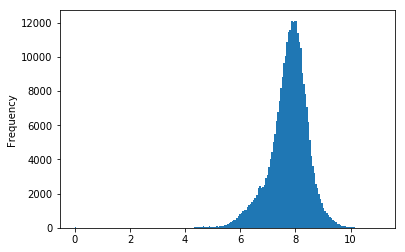

In [18]:
np.log(herald_data.article.str.len()).plot(kind = 'hist', bins = 200)

In [19]:
herald_data = herald_data[herald_data.article.str.len() > np.exp(5)]

Now there are still some html-esque characters in the data. We will find them, and replace them.

In [20]:
# Find all of the html-text
set(re.findall('&[A-z0-9]+;', ' '.join(herald_data.article.values)))

{'&amp;', '&gt;', '&lt;'}

In [21]:
def replace_html_text(s):
    '''
    Replace any cases of weird html strings
    '''
    return (s.replace("&amp;", "&")
             .replace('&gt;', '>')
             .replace('&lt;', '<'))

In [22]:
# Fix html text in articles
herald_data['article'] = herald_data['article'].apply(replace_html_text)

We can also fix all of the paragraphs to remove whitespace, and standardise the number of lines between paragraphs.

In [ ]:
def fix_paragraphs(s):
    '''
    Fix any paragraphs in s
    '''
    paragraphs = []
    for par in s.split("\n"):
        par = par.strip()
        if len(par) == 0:
            continue
        paragraphs.append(par)
    return "\n\n".join(paragraphs)

In [ ]:
herald_data['article'] = herald_data['article'].apply(fix_paragraphs)

In [ ]:
# Find all of the html-text
set(re.findall('<[^>]{,800}>', ' '.join(herald_data.article.values)))

{'<\n\nBCC: >',
 "<\n\nRE: Birds\n\nWe might have to reconsider our strategy. No one seems fussed by policy. It's all secret donors and milky liaisons. Given Sealord Shane's latest diatribe, how about calling for an inquiry into mollyhawks? Also mollygarchs and mollyopolies, and possibly mollycoddling. Fun stuff. Maybe we could ask Molly Ringwald to dress up as a seagull and promote solar power. Loved her in The Breakfast Club.\n\nArohanui, Clint\n\nFROM: >",
 '<\n\nRE: DPM, etc\n\nA word on the deputy prime minister plan for the inevitable Green-Labour coalition. There will be four. The two co-leaders, plus one collective consciousness and another crowd-sourced from the internet.\n\nKia Kaha\n\nMetirisell\n\nP.S. Turns out the postmodern mollyhawk is mightier than the medieval mackerel, Jonesy. Go stick that on your fracking credit card, cobber.\n\nFROM: >',
 '<\n\nRE: FW: SEEKING YOUR IMMEDIATE ASSISTANCE, FROM CLOSE AIDE TO THE FORMER PRESIDENT OF THE DEMOCRATIC REPUBLIC OF CONGO\n\

In [ ]:
article = herald_data.sample(1).article.values[0]
print(article)

This week a nation heads to the polls for one of the most important votes in its history.

Meanwhile in New Zealand we'll be deciding which of the minor parties John Key has to call first this Sunday.

Cynical? Me?

Well, there's no doubt the stakes around the Scottish independence vote on Thursday are historic in scale. Here in New Zealand you could make the case - and plenty on the left do - that this election also represents a chance for historic change. You could make that case but, with just days to go, the polls suggest a large chunk of the public just aren't with you.

Even after the revelations of the Dirty Politics saga and the late departure of a senior government minister, it does not feel as if there is great momentum for historic political change right now.

Despite the scandals which ignited the early part of the campaign, things seem to have settled back to a quieter, more concerted debate.

Last week it seemed as if there was a bigger buzz about the Apple smartwatch and

In [ ]:
if not os.path.exists('../data/articles.corpus') or OVERWRITE:
    with open('../data/articles.corpus', 'w') as corpus_file:
        for i, row in herald_data.iterrows():
            corpus_file.write('\n'.join([row['headline'], row['article']]) + "\n\n")

In [ ]:
if not os.path.exists("../data/herald_data.csv") or OVERWRITE:
    herald_data.to_csv("../data/herald_data.csv", index = False)

In [ ]:
herald_data = herald_data.reindex()

In [ ]:
herald_data.reset_index(drop = True, inplace = True)

In [ ]:
herald_data.info()